# Integer Program Formulation
This notebook outlines an integer programming perspective on the Covid-19 scheduling problem. In its current iteration, this model schedules people on a week-by-week basis, ensuring that people take 2 tests per week (if feasible) and attempting to keep the number of tests on any given day below a reasonable bound.

The optimized variable is a $assignment$, a $(number\_of\_people, 7)$ binary matrix where each row is the weekly schedule for one person, where 0 means 'no test' and 1 means 'test'. We can incorporate $avail$, which is a $(number\_of\_people 7)$ binary matrix that marks on which days people are on campus (0 is not on campus, 1 is on campus and available to test). This way, multiplying $avail$ by $assignment$ elementwise and summing across rows gives a $ number\_of\_people $ vector with the counts of well-scheduled tests that week for each person. Moreover, summing $ assignment$ across columns gives the total number of tests per day, which we want to keep fairly even.

<!-- The optimized variable is $x0$, a $(7*number\_of\_people)$-length vector that gives a schedule for each person — the schedule is a subvector of 7 binary digits, with 0 meaning 'no test' and 1 meaning 'test'.

To incorporate people's availabilities (here, availability for a test = on campus that day), we use a $(number\_of\_people) * (7*number\_of\_people)$ matrix $A_{eq}$, which has binary 7-vectors down the diagonal that incorporate people's availabilities (0 = not available, 1 = available). This way, $A_{eq} \cdot x0 $ will return the number of scheduled tests that align with each person's schedule.

We also use a binary matrix $A$ that when dotted with $x0$ gives a 7-vector of total tests per day, to ensure that each day's testing does not exceed a certain threshold. The threshold $b$ is simply the average number of tests per day: $\frac{(number\_of\_people*tests\_per\_week)}{7} * (1 + \mbox{buf})$, where buf is currently set to 0.05. -->

In [1367]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
from matplotlib import colors

# setup

In [1609]:
tests_per_week = 2
number_of_people = 20
buffer = .05
def runSetup():
    avail = np.random.randint(0,2, size=(number_of_people, 7)) # random availabilities

    spaces = np.ones((number_of_people,))

    # Dealing with infeasibles...
    people_total_availability = np.sum(avail, 1)
    infeasible_people = np.where(people_total_availability < tests_per_week)
    unshiftable_people = np.where(people_total_availability <= tests_per_week)

    # Enforce that everyone gets two tests a week
    # Aeq = availability_matrix
    beq = np.multiply(tests_per_week, np.ones((number_of_people,1)))

    # Loosen beq in the case where people aren't available enough
    for i in range(len(infeasible_people[0])):
        beq[infeasible_people[0][i]][0] = people_total_availability[infeasible_people[0][i]]
        
    for i in range(len(unshiftable_people[0])):
        spaces[unshiftable_people[0][i]] += 1 # ensure that people with < test_per_week tests aren't space-constrained

    # This picks up the number of total tests (per?) person each day of the week
    testing_capacity_matrix = np.zeros((7, 7*number_of_people))
    for i in range(len(testing_capacity_matrix)):
        for j in range(i, 7*number_of_people, 7):
            testing_capacity_matrix[i][j] = 1

    A = testing_capacity_matrix
    b_value = (number_of_people*tests_per_week/7)
    b = np.multiply(b_value, np.ones((7,1)))
    
    return avail, b, beq, spaces

# cvxpy optimization

In [1630]:
avail, b, beq, spaces = runSetup()

def runOpt():
    assignment = cp.Variable((number_of_people, 7), boolean=True)

    def objective():
        expr = []
        for i in range(7):
            for j in range(i + 1, 7):
                penalty = ((j - i) - 3.5)**2
                expr.append(penalty * cp.sum(assignment[:, i], assignment[:, j]))
        expr.append(cp.sum(expr))
        
    adjacences = np.zeros((6, 7))
    for i in range(6):
        adjacences[i][i] = 1
        adjacences[i][i+1] = 1

    constraints = [
        cp.sum(assignment, axis=0) <= np.ceil(b.transpose()[0] * (1 + buffer)), # set load upper bound
        cp.sum(assignment, axis=0) >= np.floor(b.transpose()[0] * (1 - buffer)), # set load lower bound
        cp.sum(assignment, axis=1) == beq.transpose()[0], # enforce test-taking
        cp.sum(cp.multiply(assignment, avail), axis=1) == beq.transpose()[0] # align with availability
    ]
    
    # Ensure each person has no consecutive days scheduled
    for i in range(6):
        constraints.append(cp.sum(cp.multiply(assignment, adjacences[i]*np.ones((number_of_people,1))), axis=1) <= spaces)

#     obj = cp.Minimize(objective())
    obj = cp.Maximize(cp.sum(assignment)) # Dummy objective function

    prob = cp.Problem(obj, constraints=constraints)
    prob.solve()

    return assignment

def analyze(assignment):
    # Compute spread score (lower is better)
    score = 0
    for week in assignment.value:
        scheduled_days = []
        for i in range(7):
            if week[i] == 1:
                scheduled_days.append(i)
        if len(scheduled_days) == 2:
            score += ((scheduled_days[1] - scheduled_days[0]) - 3.5) ** 2
    spreadScore = score / number_of_people
    
    # Compute daily demands, deviations
    daily_demands = np.sum(assignment.value, axis=0)
    exp_supply_per_day = number_of_people * tests_per_week / 7
    max_deviation = max(daily_demands.max() - exp_supply_per_day,
                        exp_supply_per_day - daily_demands.min()) / exp_supply_per_day # MIN, right?
    
    return spreadScore, daily_demands, max_deviation

assignment = runOpt()

if assignment.value is not None:
    spreadScore, daily_demands, max_deviation = analyze(assignment)
else:
    print("Situation infeasible")

Analysis/Summary

Spread score is: 1.32
Max deviation % is: 12.5
Daily demand (min): 5.0
Daily demand (max): 6.0
All daily demands: [6. 5. 6. 5. 5. 6. 5.]


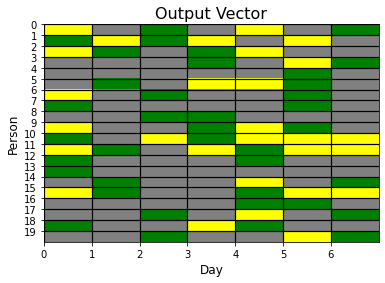

In [1631]:
print("Spread score is: %.02f" % spreadScore)
print("Max deviation %% is: %.01f" % (100 * max_deviation))
print('Daily demand (min):', daily_demands.min())
print('Daily demand (max):', daily_demands.max())
print('All daily demands:', daily_demands)

# Display Calendar

scaled_assignment = np.multiply(assignment.value, 0.5)
data = np.add(scaled_assignment, avail)

outputColors = colors.ListedColormap(['gray', 'red', 'yellow', 'green'])
availColors = colors.ListedColormap(['gray', 'yellow'])

plt.title("Output Vector", fontsize=16)
plt.imshow(data, cmap=outputColors, aspect='auto', extent=[0, 7, number_of_people, 0])
plt.grid(which='major', axis='both', linestyle='-', color='k', linewidth=1.2)
plt.xticks(np.arange(0,7, 1))
plt.yticks(np.arange(0, number_of_people, 1))

plt.xlabel("Day", fontsize=12)
plt.ylabel("Person", fontsize=12)
plt.savefig('output.png', dpi=300, bbox_inches='tight')
plt.show()

Run many trials to check distributions of spread score, etc.

In [1614]:
%%time
spreads = []
devs = []
infeasible = 0
for t in range(1000):
#     if (t%50 == 0):
#         print(t)
    avail, b, beq, spaces = runSetup()
    assignment = runOpt()
    if assignment.value is not None:
        spreadScore, daily_demands, max_deviation = analyze(assignment)
        spreads.append(spreadScore)
        devs.append(100 * max_deviation)
    else:
        infeasible += 1
print("There were %d infeasible situations" % infeasible)

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
There were 45 infeasible situations
CPU times: user 15.4 s, sys: 171 ms, total: 15.5 s
Wall time: 16.3 s


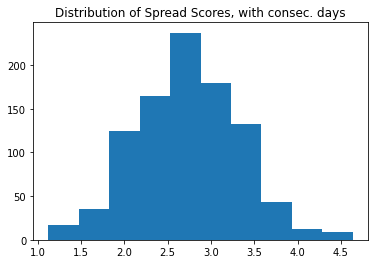

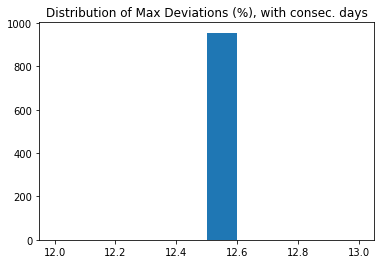

In [1615]:
plt.title("Distribution of Spread Scores, with consec. days")
plt.hist(spreads)
plt.savefig('spreads_Consec.png', dpi=300, bbox_inches='tight')
plt.show()

plt.title("Distribution of Max Deviations (%), with consec. days")
plt.hist(devs)
plt.savefig('maxDev_Consec.png', dpi=300, bbox_inches='tight')
plt.show()